In [1]:
from __future__ import print_function, division

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit
#from sklearn.cross_validation import train_test_split

In [3]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

# Build Models from icd9-code features created using Likelihood model


This notebook uses the data : **data tables** : new_alive, new_icd9


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]



In [4]:
df = pd.read_csv('mimic_data/data_model1.csv')

In [5]:
df[:3]

,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,07031,07041,1481,...,85205,85225,9878,99685,99688,E9278,V1062,V143,V4578,V568
0,121205,91,1,F,EMERGENCY,FEVER,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183686,94,1,M,EMERGENCY,SEPSIS,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140037,94,1,M,EMERGENCY,PNEUMONIA,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

In [7]:
df.dropna(inplace=True)

Do I have any instances where I have too few data points? For instance, maybe fore one or two diagnoses maybe I only have 2 cases, is that enough to establish odds of survival? 

Count the number of 1's or instances, of each diagnosis
Count the number of instances with Expire/not flag

In [8]:
exclude = ['hadm_id', 'subject_id', 'expire_flag', 'gender', 'admission_type',
       'diagnosis', 'age']
diagnosis_codes = df.columns.tolist()
diagnosis_codes
#diagnosis_codes.remove('hadm_id','age')

diagnosis_codes = [x for x in diagnosis_codes if x not in exclude]

In [9]:
len(diagnosis_codes)

47

In [10]:
num_cases = []
for a in diagnosis_codes:
    count = df.iloc[df[a].nonzero()][a].count()
    num_cases.append(count)


In [11]:
df_count = pd.DataFrame(num_cases, index=diagnosis_codes, columns=['count_fatal'])

In [12]:
df_count.sort_values('count_fatal',ascending=False)

,count_fatal
1972,289
99685,184
51181,179
1984,128
58281,121
485,102
20510,100
1971,82
85225,51
V4578,49


In [13]:
#df_count#.count_fatal.plot()

In [14]:
# df['07031'].hist()
df.iloc[df['07031'].nonzero()]['07031'].count()#['07031']#.count()


18

In [15]:
"""
    array of all diagonses codes with their value of 1.0 counts
    diagnosis in one column and count of fatalaties in the other

"""

'\n    array of all diagonses codes with their value of 1.0 counts\n    diagnosis in one column and count of fatalaties in the other\n\n'

In [16]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df.admission_type.unique())

df.admission_type.replace(cols, nums, inplace=True)

['EMERGENCY' 'ELECTIVE' 'URGENT' 'NEWBORN']


In [17]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df.gender.replace(gen, n_g, inplace=True)

In [18]:
#df.info()

In [19]:
"""
    build pr-curve comparing ground truth with model score
    truthvec - truth vectore
    scorevec - score vector
    s - type of classifier , eg. 'logistic', 'random forest' etc.
"""

def pr_curve(truthvec, scorevec, s, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec, label=s)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend()
    return (recallvec, precisionvec, threshvec)

In [20]:
# exclude diagnosis from the fit
df.columns.values
cols = ['gender', 'admission_type',
       'age', '07031', '07041', '1481', '1519', '1530',
       '1560', '1715', '1910', '1965', '1971', '1972', '1984', '20030',
       '20510', '2468', '25023', '27953', '29389', '3581', '36001',
       '36019', '36400', '3643', '3693', '37239', '37900', '4449', '46611',
       '485', '48801', '51181', '5581', '58281', '6829', '72290', '73004',
       '78939', '85205', '85225', '9878', '99685', '99688', 'E9278',
       'V1062', 'V143', 'V4578', 'V568'] # 'hadm_id', 'subject_id', 'expire_flag','diagnosis'

X = df.loc[:, cols]
y = df.loc[:,'expire_flag']

# Logistic Model: Gender, Age, Admission type + ICD9 codes

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [22]:
"""
    make an instance of a Logistic Regression Model 
"""

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
y_pred_lr = lr_model.fit(X_train, y_train).predict_proba(X_test)

In [24]:
lr_vec = y_pred_lr[:,1]

In [28]:
"""
    ValueError: Can't handle mix of binary and continuous-multioutput
"""
#accuracy_score(y_test, y_pred_lr, normalize=True)

"\n    ValueError: Can't handle mix of binary and continuous-multioutput\n"

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,lr_vec)


0.7851113843579393

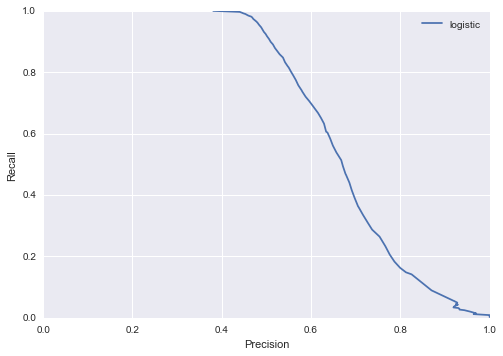

In [32]:
pr_curve(y_test, lr_vec,'logistic');

## Evaluation
prediction = predicts the outcome vectors 

### Confusion matrix 

In [35]:
# for confusion matrix use method .predict, to get the predicted label, not probability
prediction = lr_model.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_test, prediction, normalize=True)

In [36]:
"""
    Log-loss
     appropriate performance measure when you're model output is the
     probability of a binary outcome.
     ... what is 9.74  
"""
log_loss(y_test, prediction) #make sure have prediction variable 

9.741654903963198

##### Log Loss is really high
suggesting probably many mis-labeled data?  Log Loss higher than 1 usually indicates a very mis-labeled data set 

In [ ]:
prediction

In [ ]:
prediction.size

In [ ]:
y_test[:3]

In [ ]:
#imported above
cm = confusion_matrix(y_test, prediction)
cm

In [ ]:
%%time
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(all_sample_title, size = 15);

Model performs best in the accuracy of true positives, followed by true negatives

Model has somewhat higher number of false negatives (than false positives) 

Model under-estimates and mis-classifies fatal cases at higher rates than non-fatal. 

## Classification report 

In [ ]:
from sklearn.metrics import classification_report

y_pred = prediction
y_true = y_test
target_names =  ['fatal', 'non-fatal']
print(classification_report(y_true, y_pred, target_names=target_names))

# Evaluation by Cross-validation

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold


## us lr_model above
lr_model

In [ ]:
"""
    try starting out with cv = 5 folds
    For integer/None inputs, if the estimator is a classifier
    and y is either binary or multiclass, StratifiedKFold is used
"""
scores = cross_val_score(lr_model, X, y, cv=5)
print(scores)

appears to be somewhat of an improvement

In [ ]:
import sklearn
sklearn.__version__

obtaining predictions from cross-validation
http://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation


In [ ]:
#from sklearn.model_selection import cross_validate
from sklearn.cross_validation import  cross_val_predict

In [ ]:
predicted = cross_val_predict(LogisticRegression(), X, y, cv=10)


In [ ]:
print (accuracy_score(y, predicted) )
print (classification_report(y, predicted) )

In [ ]:
"""
    DO NEXT: ROC curve
"""

In [ ]:
#random forest
plt.figure()
pr_curve(y_test, rf1_pred_vec,'random forest')
pr_curve(y_test, lr_vec,'logistic regression')
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost')
#plt.savefig('pr');

In [ ]:
#################
### for predict_proba, use log-loss

# for col in X_train.columns:
#     print (col)
#     X_tr = X_train.loc[:, col].values.reshape(-1,1)
#     X_te = X_test.loc[:,col].values.reshape(-1,1)
#     lr_model = LogisticRegression()
#     lr_model.fit(X_tr, y_train)
#     y_prob_pred = lr_model.predict_proba(X_te)[:,1]
#     print( "log-loss",log_loss(y_test, y_prob_pred)) 

# Random forest + gradient boosting


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss


In [ ]:
"""
    train Classifiers first: y_pred_RF
"""
# print("accuracy \t",accuracy_score(y_test, y_pred_RF, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF))
# print ("recall \t", recall_score(y_test, y_pred_RF))
# print ('f1 \t',f1_score(y_test, y_pred_RF))

Notes
+ recall is improved when max_features is increased
+ n_estimators : does not seem to have an affect


In [ ]:
start = timeit.default_timer()
rnd = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)
elapsed = timeit.default_timer() - start
print ("Random Forest Classifier takes {} sec) ".format(elapsed))

In [ ]:
rnd.feature_importances_

In [ ]:
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)

# print("accuracy \t",accuracy_score(y_test, y_pred_RF_P, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF_P))
# print ("recall \t", recall_score(y_test, y_pred_RF_P))
# print ('f1 \t',f1_score(y_test, y_pred_RF_P))

In [ ]:
y_pred_RF_P.shape

In [ ]:
#second column 
rf1_pred_vec = y_pred_RF_P[:,1]

In [ ]:
plt.figure()
pr_curve(y_test, rf1_pred_vec);

In [ ]:
np.mean(y_test)

In [ ]:
roc_auc_score(y_test,rf1_pred_vec)

a possible way of interpreting this model : 
if I want to isolate a group of patients in the ICU with 80% precision, (80 TP/ 20 FP), so that 4/5ths have high mortality (are likely to die / WILL die) for special care, I can do this with 20% recall (Meaning we will catch only 20% of all patients who will die) 

If we want to catch more of the total patients who will die (Higher recall) 

In [ ]:
model_gb1 = GradientBoostingClassifier(n_estimators=4000,max_depth=3,learning_rate=.003)
model_gb1.fit(X_train, y_train)

In [ ]:

# predict class labels for the test set
gb1_pred_mat = model_gb1.predict_proba(X_test)
gb1_pred_vec = gb1_pred_mat[:,1]

In [ ]:
a = list(zip(X.columns, model_gb1.feature_importances_))

In [ ]:
a.sort(key=lambda tup: tup[1]) 
a

In [ ]:
('85225', 0.023728398524586445),
 ('58281', 0.02449622482246934),
 ('6829', 0.024804630629938505),
 ('20510', 0.025198270897120314),
 ('1971', 0.02572697097360083),
 ('07041', 0.025937043632540509),
 ('485', 0.031539383481972216),
 ('51181', 0.032793101127143578),
 ('99685', 0.03296745209222874),
 ('1984', 0.037243108801294431),
 ('1972', 0.04072702054898935),
 ('admission_type', 0.054172788832846458),
 ('age', 0.30028027265805535)]

In [ ]:
age, 0.3

In [ ]:
roc_auc_score(y_test,gb1_pred_vec)


In [ ]:
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost');
